# Student name: Pat O'Dowd

# Student ID: 8273375

In [80]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [81]:
df = pd.read_csv("./insurance.csv")
df.head()
set_config(transform_output='pandas')

In [82]:
# describe the data set
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

array([[<Axes: title={'center': 'age'}>]], dtype=object)

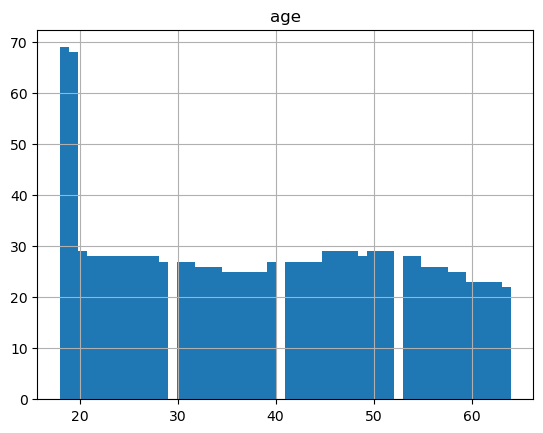

In [83]:
# Show histogram of age. Looks like the data set has a higher proportion of 18-20  year olds.
df.hist(column='age',bins=50)

<Axes: >

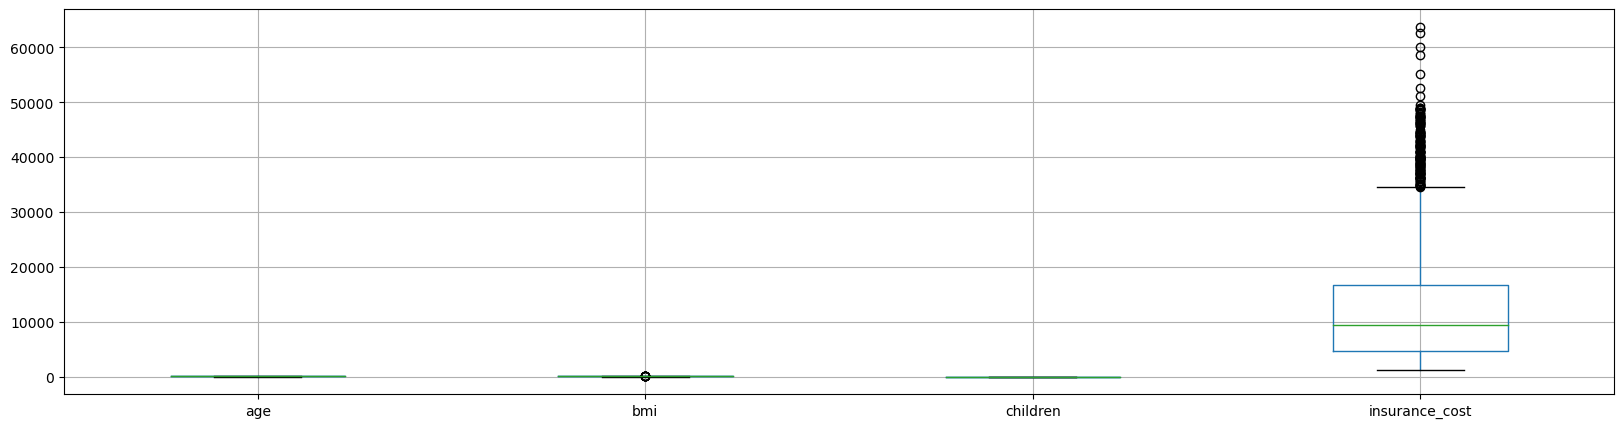

In [84]:
# Show boxplot of the numeric columns. Insurance cost has lots of outliers.
df.boxplot(figsize=(20,5))

In [85]:
# As per instructons replacing insurance cost with insurance_cost_binary where 1 is for cost > median
df['insurance_cost_binary'] = np.where(df['insurance_cost']>df['insurance_cost'].median(),1,0)
df.drop('insurance_cost', axis=1,inplace=True)
y = df['insurance_cost_binary']
X=df.drop('insurance_cost_binary', axis=1)

In [86]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost_binary
0   18    male  33.770         1     no  southeast                      0
1   18    male  34.100         0     no  southeast                      0
2   18  female  26.315         0     no  northeast                      0
3   18  female  38.665         2     no  northeast                      0
4   18  female  35.625         0     no  northeast                      0

In [87]:
# Check for null values. There are none !
df.isna().sum()

age                      0
gender                   0
bmi                      0
children                 0
smoker                   0
region                   0
insurance_cost_binary    0
dtype: int64

<Axes: >

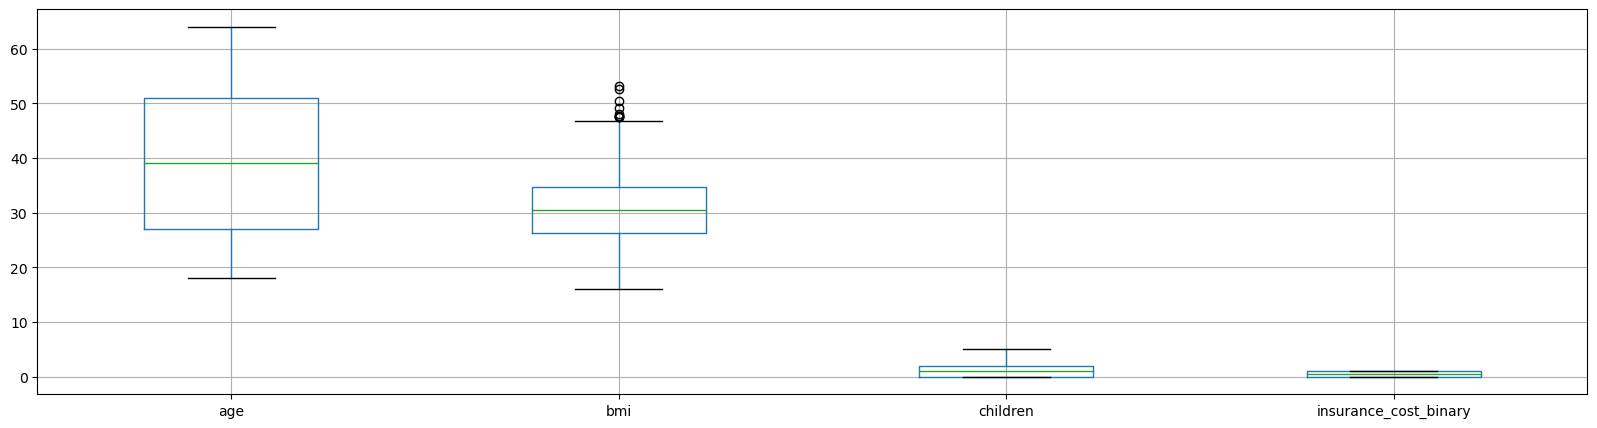

In [88]:
# Check for outliers again. Removing insurance cost we can see that BMI has outliers.
df.boxplot(figsize=(20,5))

In [89]:
# Creating a customer transformer class for bmi category instead of BMI
class bmi_category(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Map BMI to BMI Category underweight to obese
        X['bmi'] = np.where(X['bmi']<18.5,0.0,X['bmi'])
        X['bmi'] = np.where((X['bmi']>=18.5) & (X['bmi']<25),0.2,X['bmi'])
        X['bmi'] = np.where((X['bmi']>=25) & (X['bmi']<30),0.4,X['bmi'])
        X['bmi'] = np.where((X['bmi']>=30) & (X['bmi']<35),0.6,X['bmi'])
        X['bmi'] = np.where((X['bmi']>=35) & (X['bmi']<40),0.8,X['bmi'])
        X['bmi'] = np.where((X['bmi']>=40),1.0,X['bmi'])
        

        return X

# Creating a customer transformer class for age category instead of age. However decided not to use this
# transformation as it negatively impacted the results.

class age_category(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Map Age to Age Group 
        X['age'] = np.where(X['age']<20,0.0,X['age'])
        X['age'] = np.where((X['age']>=20) & (X['age']<26),0.2,X['age'])
        X['age'] = np.where((X['age']>=26) & (X['age']<36),0.4,X['age'])
        X['age'] = np.where((X['age']>=36) & (X['age']<46),0.6,X['age'])
        X['age'] = np.where((X['age']>=46) & (X['age']<56),0.8,X['age'])
        X['age'] = np.where((X['age']>=56),1.0,X['age'])

        

        return X
# A functon transformer method to convert yes/no to binary.
def yes_no_to_binary(df):   
    return df.apply(lambda x: x.replace({'yes': 1, 'no': 0}))



In [90]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost_binary
0   18    male  33.770         1     no  southeast                      0
1   18    male  34.100         0     no  southeast                      0
2   18  female  26.315         0     no  northeast                      0
3   18  female  38.665         2     no  northeast                      0
4   18  female  35.625         0     no  northeast                      0

In [91]:
# Add in various transformers.

# Function transformer to convert yes/no values to binary

smoker_transformer = FunctionTransformer(func=yes_no_to_binary)

# One hot encoder
oneHotEncoder_pipeline = Pipeline(
    steps = [
        ("oneHotEncoder", OneHotEncoder(sparse_output=False)
        )
    ]
)
# Transformer to convery bmi to bmi category
bmi_transformer = Pipeline(
    steps = [
        ("bmi_transformer", bmi_category()),
    ]
)

# Transformer to convert age to age group. Decided not to use this as the metrics came out better leaving age as a value

age_transformer = Pipeline(
    steps = [
        ("age_transformer", age_category()),
    ]
)



outliers_and_zeros_pipeline = Pipeline(
    steps = [
        ("cubic_root_transform", FunctionTransformer(np.cbrt)),
        ("scaler", RobustScaler())
    ]
)


standard_scaler = Pipeline(
    steps = [
        ("scaler", StandardScaler())
    ]
)


preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("oneHotEncoder", oneHotEncoder_pipeline, ['region','gender']),
        ('bmi_transformer',bmi_transformer, ['bmi']),
        ('smoker_transformer',smoker_transformer,['smoker']),
#        ('age_transformer',age_transformer, ['age']),
        ('standard_scaler',standard_scaler, ['age','children'])  
    ],
    remainder="passthrough" # note there are no remaining columns in this example
)

In [92]:
# Setup up data for X and y
y = df['insurance_cost_binary']
X = df.drop('insurance_cost_binary', axis=1)

In [93]:
# Split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## Train on SVM

In [94]:
# create the pipeline
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('svm', svm.SVC(probability=True))
])


In [95]:
# Show the pipeline
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oneHotEncoder',
                                                  Pipeline(steps=[('oneHotEncoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['region', 'gender']),
                                                 ('bmi_transformer',
                                                  Pipeline(steps=[('bmi_transformer',
                                                                   bmi_category())]),
                                                  ['bmi']),
                                                 ('smoker_transformer',
                                                  FunctionTransformer(func=<function yes_no_to_binary at 0x1436ea020>),
                                                  ['smoker']),
                                                 ('standard_scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'children'])])),
                ('reduce_dim', 'passthrough'), ('svm', SVC(probability=True))])

In [96]:
# Fit the model
svm_model=pipe.fit(X,y)

In [97]:
# Preview the preprocessed data. 
preprocessed_data = pipe[:-1].transform(df)
preprocessed_data

oneHotEncoder__region_northeast  oneHotEncoder__region_northwest  \
0                                 0.0                              0.0   
1                                 0.0                              0.0   
2                                 1.0                              0.0   
3                                 1.0                              0.0   
4                                 1.0                              0.0   
...                               ...                              ...   
1333                              1.0                              0.0   
1334                              0.0                              1.0   
1335                              1.0                              0.0   
1336                              0.0                              0.0   
1337                              0.0                              0.0   

      oneHotEncoder__region_southeast  oneHotEncoder__region_southwest  \
0                                 1.0                              0.0   
1                                 1.0                              0.0   
2                                 0.0                              0.0   
3                                 0.0                              0.0   
4                                 0.0                              0.0   
...                               ...                              ...   
1333                              0.0                              0.0   
1334                              0.0                              0.0   
1335                              0.0                              0.0   
1336                              1.0                              0.0   
1337                              1.0                              0.0   

      oneHotEncoder__gender_female  oneHotEncoder__gender_male  \
0                              0.0                         1.0   
1                              0.0                         1.0   
2                              1.0                         0.0   
3                              1.0                         0.0   
4                              1.0                         0.0   
...                            ...                         ...   
1333                           1.0                         0.0   
1334                           1.0                         0.0   
1335                           0.0                         1.0   
1336                           0.0                         1.0   
1337                           0.0                         1.0   

      bmi_transformer__bmi  smoker_transformer__smoker  standard_scaler__age  \
0                      0.6                           0             -1.509965   
1                      0.6                           0             -1.509965   
2                      0.4                           0             -1.509965   
3                      0.8                           0             -1.509965   
4                      0.8                           0             -1.509965   
...                    ...                         ...                   ...   
1333                   0.6                           0              1.765289   
1334                   0.4                           1              1.765289   
1335                   0.4                           0              1.765289   
1336                   0.8                           1              1.765289   
1337                   0.2                           1              1.765289   

      standard_scaler__children  
0                     -0.078767  
1                     -0.908614  
2                     -0.908614  
3                      0.751079  
4                     -0.908614  
...                         ...  
1333                   0.751079  
1334                  -0.908614  
1335                  -0.908614  
1336                   0.751079  
1337                  -0.908614  

[1338 rows x 10 columns]

In [98]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values
N_FEATURES_OPTIONS = [2,6,8]
param_grid = [
    {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly'],
    'reduce_dim': [PCA(iterated_power=7)],
    'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
    {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly'],
    'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
    'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,

    },
        {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf'],
    'reduce_dim': [ LinearDiscriminantAnalysis()],


    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #training happens here! SVM is trained 576x5 = 2880 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.936:
Best parameters:  {'reduce_dim': PCA(iterated_power=7, n_components=8), 'reduce_dim__n_components': 8, 'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


## Train on Random Forest

In [99]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

In [100]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oneHotEncoder',
                                                  Pipeline(steps=[('oneHotEncoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['region', 'gender']),
                                                 ('bmi_transformer',
                                                  Pipeline(steps=[('bmi_transformer',
                                                                   bmi_category())]),
                                                  ['bmi']),
                                                 ('smoker_transformer',
                                                  FunctionTransformer(func=<function yes_no_to_binary at 0x1436ea020>),
                                                  ['smoker']),
                                                 ('standard_scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'children'])])),
                ('rf', RandomForestClassifier())])

In [101]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
param_grid = {
    'rf__n_estimators' : [30,50,60],
    'rf__max_depth': [2, 4, 6, 8,9],
    'rf__criterion': ['gini','entropy','log_loss']
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.937:
Best parameters:  {'rf__criterion': 'gini', 'rf__max_depth': 8, 'rf__n_estimators': 60}


## Train on MLPClassifier

In [102]:
# create the pipeline
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('mlp', MLPClassifier())
])

In [103]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oneHotEncoder',
                                                  Pipeline(steps=[('oneHotEncoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['region', 'gender']),
                                                 ('bmi_transformer',
                                                  Pipeline(steps=[('bmi_transformer',
                                                                   bmi_category())]),
                                                  ['bmi']),
                                                 ('smoker_transformer',
                                                  FunctionTransformer(func=<function yes_no_to_binary at 0x1436ea020>),
                                                  ['smoker']),
                                                 ('standard_scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'children'])])),
                ('mlp', MLPClassifier())])

In [104]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
param_grid = {
    'mlp__hidden_layer_sizes': [2, 3, 4],   
    'mlp__solver': ['sgd', 'adam', 'lbfgs'],
    'mlp__activation': ['logistic', 'relu'],
    'mlp__max_iter' : [1000]

}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

/Users/patodowd/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/patodowd/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/patodowd/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/patodowd/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/patodowd/anac

Best CV score = 0.944:
Best parameters:  {'mlp__activation': 'logistic', 'mlp__hidden_layer_sizes': 2, 'mlp__max_iter': 1000, 'mlp__solver': 'lbfgs'}


In [105]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [106]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [107]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)

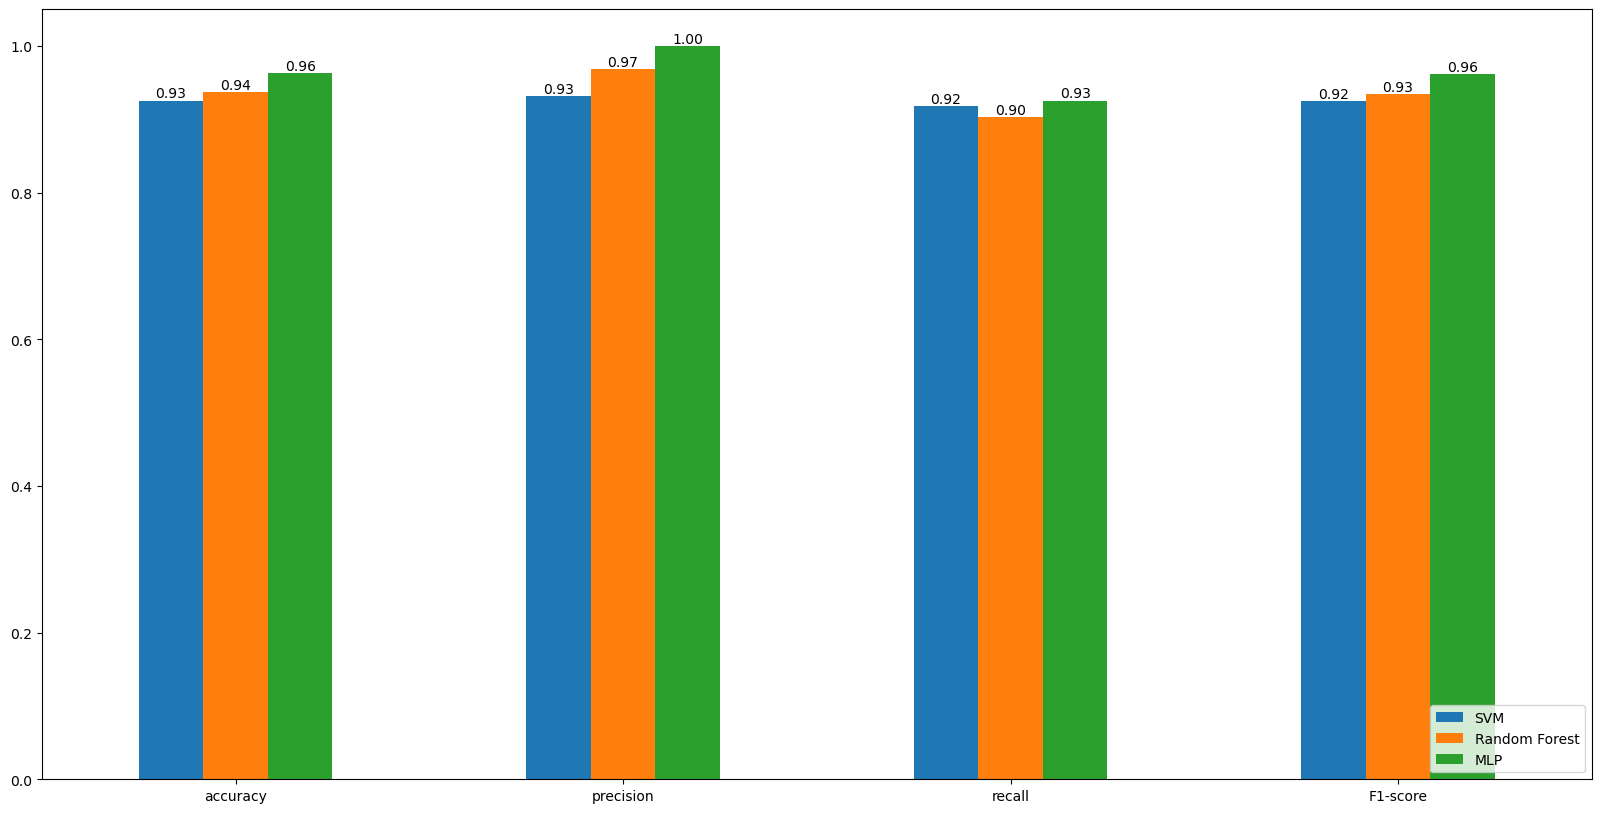

In [108]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics,'MLP': MLP_metrics}, index=index)
ax=df_metrics.plot.bar(rot=0,figsize=(20, 10)) 
ax.bar_label(ax.containers[0],fmt='%.2f')
ax.bar_label(ax.containers[1],fmt='%.2f')
ax.bar_label(ax.containers[2],fmt='%.2f')
plt.legend(loc="lower right")
plt.igsize=(10,10)
plt.show()

In [109]:
print(SVM_metrics)
print(RF_metrics)
print(MLP_metrics)


[0.92537313 0.93181818 0.91791045 0.92481203]
[0.93656716 0.968      0.90298507 0.93436293]
[0.96268657 1.         0.92537313 0.96124031]


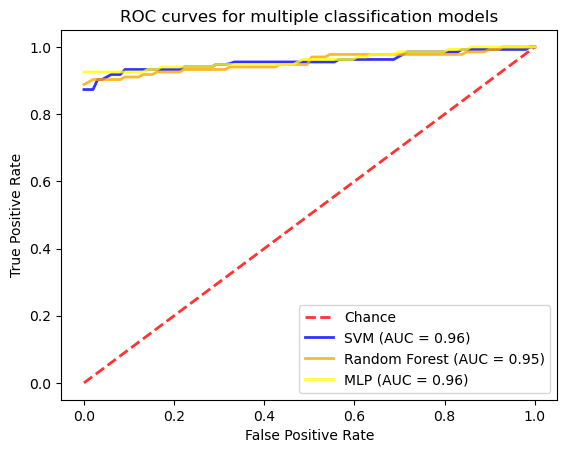

In [110]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=2, color='yellow', label='MLP (AUC = %0.2f)' % (MLP_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

In [111]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('mlp__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, MLP_best_params.get('reduce_dim'),MLPClassifier(**transform(MLP_best_params)))

final_model =pipe.fit(X, y)

In [112]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

# Summary of Results
In terms of results the all the classifiers performed in a very similiar manner. MLP seemed to generally get best results dependent on the run. 
The SVM model shows best performance using the RBF kernel and with a high value for C=100 indicating a narrow margin. In terms of the additional reduction dimension method, I selected the linear discriminant analysis (LDA). And the best dimension reduction was done with SVR. I also initially tried the NeighborhoodComponentsAnalysis but it was iterating through Max_iter=50 for each combination and therefore taking a very long time to process. 
Tweaking the RF parameters got the CV score close to or exactly the same as the CV score for SVM but SVM seemed slightly better on the final results as per the ROC curve. However the MLP AUC topped both SVM and RF on most runs and would probably be the solution i would select.  